In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import gudhi
import numpy as np
import pandas as pd

from functions.data_processing import sublevelset_persistence, remove_outliers_z_score, remove_outliers_dbscan
from functions.data_loading import get_condensed_distance_matrix, flights_from_query, get_flight_persistances
from functions.plotting import plot_scatter_matrix

from scipy.cluster.hierarchy import fcluster, linkage
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from traffic.core import Traffic, Flight

Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\0004379eeabffb8125367454e1c5aed7.parquet created on 1741559260.7848952
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\000625351770a2de4bc0da3f7566c8f1.parquet created on 1741549316.337027
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\0061061d48db51fb5dbd5d6825b7212b.parquet created on 1741549731.408295
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\00675b53ca368123cb04dab1a60bc37d.parquet created on 1741545959.1258068
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\00b02c2f5d8713edb9f7cfaae31171a0.parquet created on 1741547784.1235256
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\00ee6fbcbfded87fa8666f8ae88685c8.parquet created on 1741548155.3231537
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\00ffab7860dcfccab6c361d796497eaa.parquet created on 1741560756.8628945
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\01192566066ea4b1b1c229824

In [20]:
# load minimum data set
df = pd.read_csv("data/go_arounds_augmented.csv", low_memory=False)
df["time"] = pd.to_datetime(df["time"])

start = datetime.datetime(year=2019, month=1, day=1).replace(
    tzinfo=datetime.timezone.utc
)
stop = datetime.datetime(year=2019, month=6, day=1).replace(
    tzinfo=datetime.timezone.utc
)

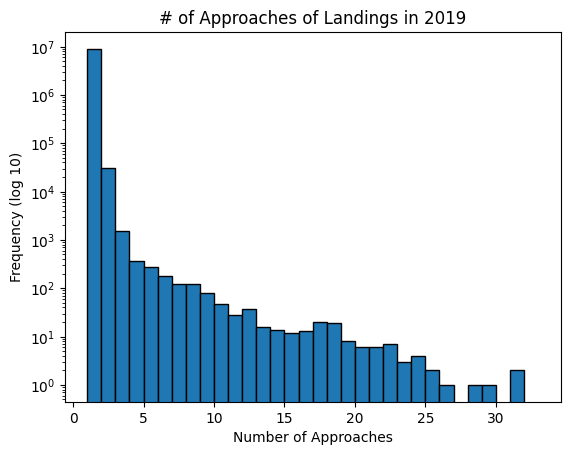

In [21]:
plt.figure()
plt.hist(df["n_approaches"], log=True, bins=range(1, 34), edgecolor = "black")
plt.xlabel("Number of Approaches")
plt.ylabel("Frequency (log 10)")
plt.title("# of Approaches of Landings in 2019")
plt.savefig("approach_histogram.svg", format="svg")
#plt.close()

In [22]:
approach_1 = df.query(f"n_approaches==1 & (@start <= time <= @stop)")
approach_2 = df.query(f"n_approaches==2 & (@start <= time <= @stop)")
approach_3 = df.query(f"n_approaches==3 & (@start <= time <= @stop)")
approach_4 = df.query(f"n_approaches==4 & (@start <= time <= @stop)")

len_4 = approach_4.shape[0]
len_3 = approach_3.shape[0]
len_2 = (len_4 + len_3) * 2
len_1 = (len_4 + len_3 + len_2) * 2

approach_4 = approach_4.sample(n=len_4, random_state=42)
approach_3 = approach_3.sample(n=len_3, random_state=42)
approach_2 = approach_2.sample(n=len_2, random_state=42)
approach_1 = approach_1.sample(n=len_1, random_state=42)

query = pd.concat([approach_1, approach_2, approach_3, approach_4], axis=0)

In [25]:
train, test = train_test_split(query, train_size=0.8, test_size=0.2, random_state=42)

Text(0.5, 1.0, 'Test dataset landing distribution')

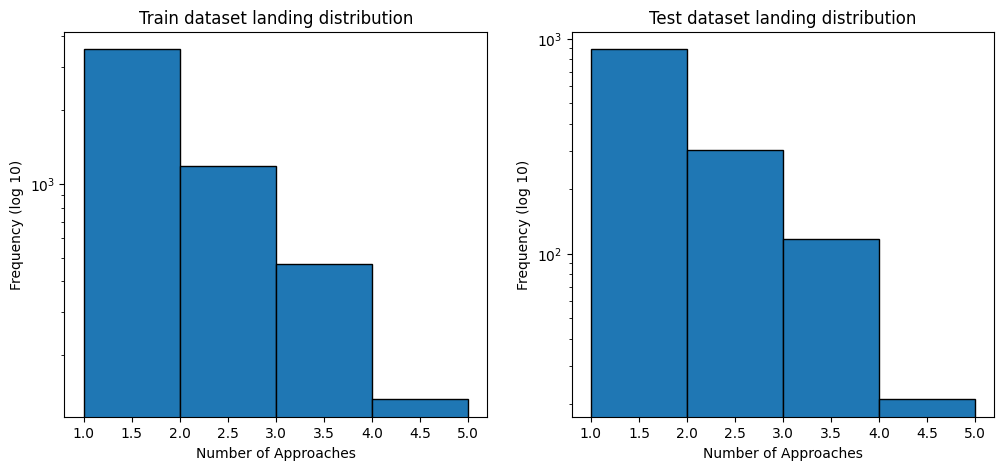

In [40]:
train_data = train["n_approaches"]
test_data = test["n_approaches"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(train_data, log=True, bins=range(1, max(train_data)+2), edgecolor = "black")
ax1.set_xlabel("Number of Approaches")
ax1.set_ylabel("Frequency (log 10)")
ax1.set_title("Train dataset landing distribution")

ax2.hist(test_data, log=True, bins=range(1, max(test_data)+2), edgecolor = "black")
ax2.set_xlabel("Number of Approaches")
ax2.set_ylabel("Frequency (log 10)")
ax2.set_title("Test dataset landing distribution")

In [44]:
file_name = "unbalanced_train"
flights, labels, stats = flights_from_query(train, file_name, load_results=False)
data = get_flight_persistances(flights, file_name, load_results=False)

100%|██████████| 3962/3962 [00:16<00:00, 238.22it/s]


In [45]:
file_name = "unbalanced_test"
flights, labels, stats = flights_from_query(test, file_name, load_results=False)
data = get_flight_persistances(flights, file_name, load_results=False)

100%|██████████| 990/990 [00:03<00:00, 261.94it/s]


In [29]:
approach_1 = train.query(f"n_approaches==1 & (@start <= time <= @stop)")
approach_2 = train.query(f"n_approaches==2 & (@start <= time <= @stop)")
approach_3 = train.query(f"n_approaches==3 & (@start <= time <= @stop)")

len_3 = approach_3.shape[0]

approach_3 = approach_3.sample(n=len_3, random_state=42)
approach_2 = approach_2.sample(n=len_3, random_state=42)
approach_1 = approach_1.sample(n=len_3, random_state=42)

balanced_train = pd.concat([approach_1, approach_2, approach_3], axis=0)

In [30]:
approach_1 = test.query(f"n_approaches==1 & (@start <= time <= @stop)")
approach_2 = test.query(f"n_approaches==2 & (@start <= time <= @stop)")
approach_3 = test.query(f"n_approaches==3 & (@start <= time <= @stop)")

balanced_test = pd.concat([approach_1, approach_2, approach_3], axis=0)

1311
1410


Text(0.5, 1.0, 'Test dataset landing distribution')

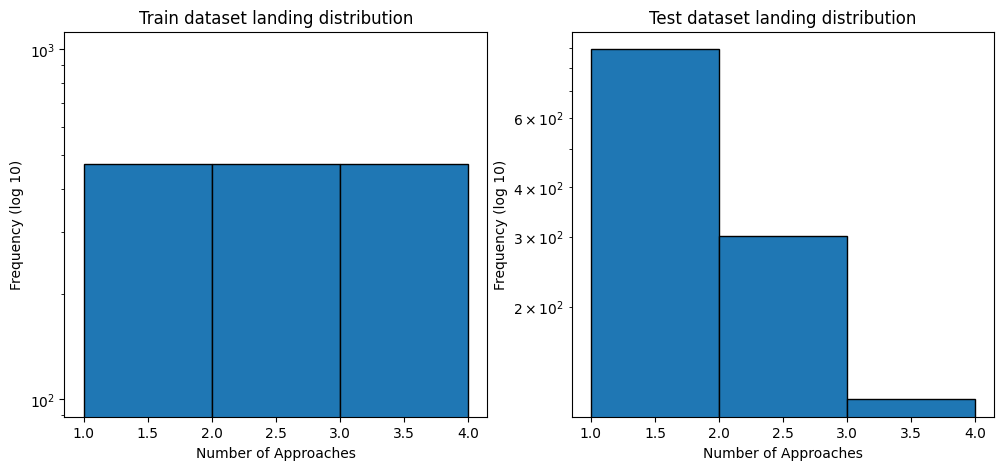

In [39]:
train_data = balanced_train["n_approaches"]
test_data = balanced_test["n_approaches"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(train_data, log=True, bins=range(1, max(train_data)+2), edgecolor = "black")
ax1.set_xlabel("Number of Approaches")
ax1.set_ylabel("Frequency (log 10)")
ax1.set_title("Train dataset landing distribution")

ax2.hist(test_data, log=True, bins=range(1, max(test_data)+2), edgecolor = "black")
ax2.set_xlabel("Number of Approaches")
ax2.set_ylabel("Frequency (log 10)")
ax2.set_title("Test dataset landing distribution")

In [42]:
file_name = "balanced_train"
flights, labels, stats = flights_from_query(balanced_train, file_name, load_results=True)
data = get_flight_persistances(flights, file_name, load_results=True)

100%|██████████| 949/949 [00:04<00:00, 237.19it/s]


In [43]:
file_name = "balanced_test"
flights, labels, stats = flights_from_query(balanced_test, file_name, load_results=True)
data = get_flight_persistances(flights, file_name, load_results=True)

100%|██████████| 986/986 [00:04<00:00, 233.12it/s]


In [ ]:
data = labels[:, 0]

plt.figure()
y, _, _ = plt.hist(data, log=True, bins=range(1, 5), edgecolor = "black")
plt.xlabel("Number of Approaches")
plt.ylabel("Frequency (log 10)")
plt.ylim(1, max(y)*1.25 )
plt.title("# of Approaches in Landings of Balanced Dataset")
plt.savefig("balanced_1_2_3_approach_histogram.svg", format="svg")
#plt.close()

In [ ]:
index = 1500

flight_data = flights[index].data[["latitude", "longitude", "groundspeed", "vertical_rate", "geoaltitude"]]

plot_scatter_matrix(flight_data)

In [ ]:
trees, paths = sublevelset_persistence(flights[:1000], "geoaltitude")

In [ ]:
condensed_distance_matrix = get_condensed_distance_matrix(trees, file_name=file_name, load_results=True)

Z = linkage(condensed_distance_matrix, "complete")

In [ ]:
clustering = fcluster(Z, t=10, criterion='maxclust')

for i in range(1, len(np.unique(clustering))+1):
    print(f"{i}: {sum(clustering == i)}")

In [ ]:
from matplotlib import pyplot as plt

ind = 10

flight = flights[np.where(clustering == ind)[0][0]]
tree = trees[np.where(clustering == ind)[0][0]]
points = paths[np.where(clustering == ind)[0][0]]
before = flight.data[["geoaltitude"]].to_numpy()
before = np.column_stack((np.arange(len(data)), before))

dbscan_paths  = before[remove_outliers_dbscan(before, 25, eps = 0.05)]
z_score_paths = before[remove_outliers_z_score(before)]

path_filters  = [(before, "before"), (z_score_paths, "z-score"), (dbscan_paths, "dbscan")]

fig, axs = plt.subplots(3)#, sharex=True, sharey=True)
for i, (path, name) in enumerate(path_filters):
    axs[i].scatter(path[:, 0], path[:, 1])
    axs[i].set_title(name)

fig.set_figheight(10)
fig.set_figwidth(10)

In [ ]:
gudhi.persistence_graphical_tools.plot_persistence_diagram(tree, axes=axs[1])
print(tree)

In [ ]:
fig = plt.scatter(points[:, 1], points[:, 0])
plt.show()